In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.options.mode.chained_assignment = None 

In [3]:
# https://www.kaggle.com/becksddf/churn-in-telecoms-dataset
df = pd.read_csv('../data/telecom_churn.csv')

In [4]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [6]:
df['Churn'] = df['Churn'].astype(int)

## Prepare data

In [7]:
y = df['Churn']
X_all = df.drop(columns='Churn')

In [8]:
import sys
sys.path.append("../")

In [9]:
# custom transformers
from transformers.dummy_transformer import DummyTransformer
from transformers.item_selector import ItemSelector

In [10]:
from sklearn.pipeline import Pipeline

In [11]:
df.describe(include=['object', 'bool'])

,State,International plan,Voice mail plan
count,3333,3333,3333
unique,51,2,2
top,WV,No,No
freq,106,3010,2411


In [12]:
num_cols = list(X_all.select_dtypes([np.number]).columns)
num_cols

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

In [13]:
dummy_cols = ['State', 'International plan', 'Voice mail plan']

In [14]:
X_num = X_all[num_cols]

In [15]:
dt = DummyTransformer(columns_to_dummies=dummy_cols)

## Apply classifiers

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=.2)

In [18]:
predictor = GradientBoostingClassifier()
# predictor = xgb.XGBClassifier()


In [19]:
# pred_pipe = Pipeline(steps=[
#     ("prepare", dt),
#     ("predict", predictor)
# ])

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [36]:
KNeighborsClassifier?

In [29]:
knn = KNeighborsClassifier()
pred_pipe = Pipeline(steps=[
    ("prepare", dt),
    ("scale", MinMaxScaler()),
    ("predict", knn)
])

In [30]:
pred_pipe.fit(X_train, y_train);

In [31]:
y_pred = pred_pipe.predict(X_test)

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [33]:
roc_auc_score(y_test, y_pred)

0.5611615898811192

In [34]:
accuracy_score(y_test, y_pred)

0.8740629685157422

In [35]:
f1_score(y_test, y_pred)

0.22222222222222218

### Measure speed

In [22]:
prep_train_data = dt.transform(X_train)

In [23]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                     gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
                     min_child_weight=1, missing=None, n_estimators=200,
                     objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                     scale_pos_weight=1, seed=0, silent=True, subsample=1)


gbc = GradientBoostingClassifier(init=None, learning_rate=0.05, loss='exponential',
                                 max_depth=10, max_features=None, max_leaf_nodes=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=200,
                                 presort='auto', random_state=None, subsample=1.0, verbose=0,
                                 warm_start=True)

In [24]:
%%timeit
xgbc.fit(prep_train_data, y_train);

13.8 s ± 687 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
gbc.fit(prep_train_data, y_train);

92.1 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
GradientBoostingClassifier?

In [27]:
xgb.XGBClassifier?

## Search params

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [37]:
np.arange(5, 55, 15)

array([ 5, 20, 35, 50])

In [38]:
np.linspace(0.1, 1, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [40]:
param_grid = \
    [
        {
        'predict': (LogisticRegression(),),
        'predict__random_state': [1, ],
        'predict__penalty': ['l1',],
        },
    
        {
        'predict': (RandomForestClassifier(),),
        'predict__random_state': [1, ]

        },
        {
        'predict': (XGBClassifier(),),
        'predict__booster': ['gbtree'],
        'predict__gamma': [0],
        'predict__learning_rate': [0.1],
        'predict__max_depth': [4,],
        'predict__min_child_weight': [1, 2, 5],
        'predict__missing': [None],
        'predict__n_estimators': np.arange(5, 55, 15),
        'predict__objective': ['binary:logistic'],
        'predict__reg_alpha': [0.1, 0.9],
        'predict__reg_lambda': [0.1, 0.9],
        'predict__seed': [0],
    }
    ]

In [57]:
%time
gs = GridSearchCV(estimator=pred_pipe, param_grid=param_grid, 
                  scoring=['roc_auc', 'accuracy'], n_jobs=1, cv=3,
                 refit=False)
g = gs.fit(X_train, y_train);

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [60]:
g.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [49]:
# see help
GridSearchCV?

In [62]:
# RandomizedSearchCV params don't support lists

# params = {
#         'predict': (RandomForestClassifier(),),
#         'predict__random_state': [1, ]

#         }
params = {
        'predict': (XGBClassifier(),),
        'predict__booster': ['gbtree'],
        'predict__gamma': [0],
        'predict__learning_rate': np.linspace(0.1, 1, 5),
        'predict__max_depth': [2, 4, 6],
        'predict__min_child_weight': [1, 2, 5],
        'predict__missing': [None],
        'predict__n_estimators': np.arange(5, 50, 5),
        'predict__objective': ['binary:logistic'],
        'predict__reg_alpha': [0, 0.5, 1],
        'predict__reg_lambda': [1, 0.5, 0],
        'predict__seed': [0],
    }

In [63]:
%time
rs = RandomizedSearchCV(estimator=pred_pipe, param_distributions=params, 
                        scoring='roc_auc', n_jobs=1, cv=3)
rs.fit(X_train, y_train);

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [61]:
RandomizedSearchCV?

In [83]:
# score of the best estimator
rs.best_score_

0.90532850117484

In [46]:
estimator = gs.best_estimator_

In [47]:
type(estimator)

sklearn.pipeline.Pipeline

## Evaluate on test

In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
    f1_score, precision_score, recall_score, confusion_matrix

In [65]:
best_estimator = rs.best_estimator_

In [66]:
y_pred = best_estimator.predict(X_test)

In [67]:
roc_auc_score(y_test, y_pred)

0.8538955405170918

## Feature importance

In [68]:
best_xgb = best_estimator.named_steps["predict"]

In [69]:
print(best_xgb.feature_importances_)

[0.0140474  0.02240928 0.12369061 0.13065284 0.02122434 0.
 0.05715358 0.         0.         0.02989295 0.02116134 0.
 0.14959326 0.1407159  0.         0.14492156 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.14453696 0.         0.         0.        ]


In [71]:
columns = dt.transform(X_test).columns

In [72]:
fi = pd.DataFrame(best_xgb.feature_importances_, index=columns).sort_values(by=0, ascending=False).reset_index()

In [73]:
fi.head()

,index,0
0,Total intl minutes,0.149593
1,Customer service calls,0.144922
2,International plan=No,0.144537
3,Total intl calls,0.140716
4,Total day minutes,0.130653


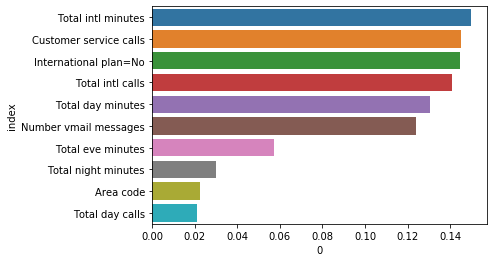

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=0, y='index', data=fi.iloc[:10] );

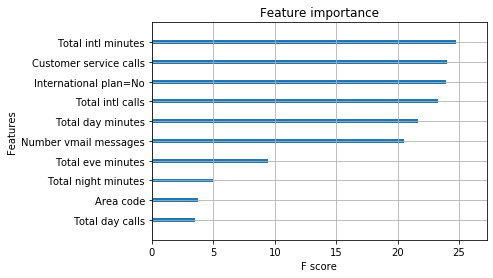

In [76]:
from xgboost import plot_importance
plot_importance(best_xgb, importance_type='gain', 
                show_values=False, max_num_features=10);

In [77]:
plot_importance?

In [92]:
best_xgb.get_booster().get_score(importance_type='gain')

{'Total day minutes': 16.106203838672137,
 'Customer service calls': 23.81587680695652,
 'International plan=No': 15.015180594791673,
 'Total intl calls': 19.418678595275864,
 'Total eve minutes': 9.858450533410524,
 'Number vmail messages': 14.187607452499995,
 'Total intl minutes': 14.24903081111628,
 'Total night calls': 2.331807951374999,
 'Total night minutes': 4.119094290803922,
 'Account length': 1.8164916671933333,
 'State=TX': 0.66505432125,
 'Total day calls': 1.9650978517142856,
 'Total eve calls': 1.8810174455,
 'Area code': 2.95595169}

### Shap values - understand your prediction

In [78]:
import shap

### read more at
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html


In [79]:
# get prepared dataframe
X_test_prep = dt.transform(X_test)

In [80]:
# load JS visualization code to notebook
shap.initjs()

In [96]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_prep)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_prep.iloc[0,:])

In [124]:
positive_class = np.where(y_pred==1)[0][0]
positive_class

1

In [125]:
shap.force_plot(explainer.expected_value, shap_values[positive_class,:], X_test_prep.iloc[positive_class,:])

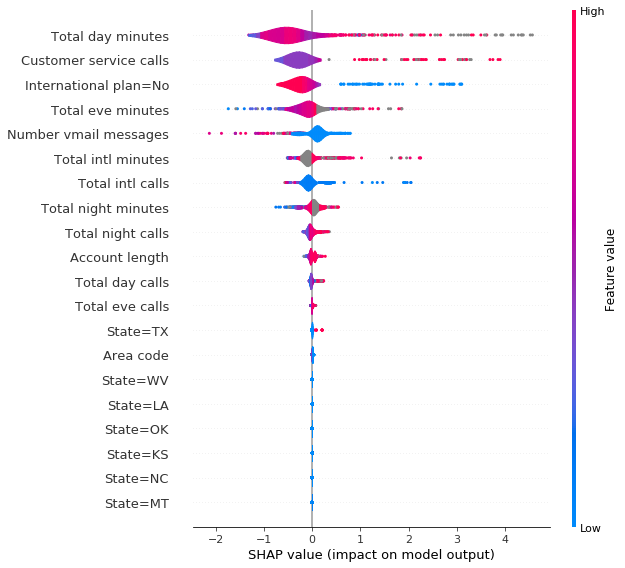

In [99]:
# draw a plot
shap.summary_plot(shap_values, X_test_prep, plot_type="violin")

In [100]:
shap_values[0,:]

array([ 0.00313039,  0.00566727,  0.11915236, -0.66214365,  0.2004873 ,
        0.        ,  0.01603787, -0.00755381,  0.        ,  0.22677681,
       -0.18764114,  0.        ,  0.12302807,  0.19804582,  0.        ,
       -0.33441126,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00486666,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.60146904,  0.        ,  0.  

In [135]:
# interesting = np.where(y_pred != y_test)[0][:10]
interesting = np.where(y_test == 1)[0][:20]
# interesting = np.where(y_test == 0)[0][:20]

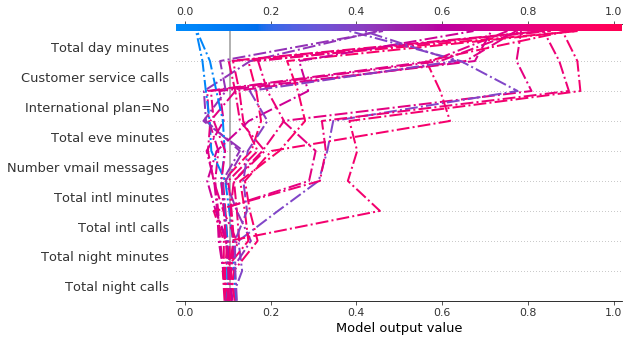

In [136]:
shap.decision_plot(explainer.expected_value, shap_values[interesting], X_test_prep.columns,
                   link='logit', 
                   highlight=slice(None),
                  feature_display_range=slice(-1, -10, -1)
                  )

In [126]:
shap.decision_plot?